In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt

import os
import numpy as np

In [2]:
#os.environ['KMP_DUPLICATE_LIB_OK'] = TRUE

In [3]:
#metrics setting
g_loss_metrics = tf.metrics.Mean(name='g_loss')
d_loss_metrics = tf.metrics.Mean(name='d_loss')
total_loss_metrics = tf.metrics.Mean(name='total_loss')

In [4]:
#hyper_parameters
ITERATION = 500
Z_DIM = 100
BATCH_SIZE = 512
BUFFER_SIZE = 60000
D_LR = 0.0004
G_LR = 0.0004
IMAGE_SHAPE = (28,28,1)
RANDOM_SEED = 42

In [5]:
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [6]:
noise = tf.random.uniform([16,Z_DIM],minval=-1,maxval=1)

In [7]:
def get_random_z(batch_size,z_dim):
    return tf.random.uniform([batch_size,z_dim],minval=-1,maxval=1)

In [8]:
#define discriminator
def make_discriminator(input_shape):
    return tf.keras.Sequential([
        layers.Conv2D(64,5,strides=2,padding='same',input_shape=input_shape),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        
        layers.Conv2D(128,5,strides=2,padding='same'),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        
        layers.Flatten(),
        layers.Dense(1)
    ])

In [9]:
D = make_discriminator(IMAGE_SHAPE)

In [10]:
#D.summary()

In [11]:
#define generator
def make_generator(input_shape):
    return tf.keras.Sequential([
        layers.Dense(7*7*256,use_bias=False,input_shape = input_shape),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        
        layers.Reshape((7,7,256)),
        
        layers.Conv2DTranspose(128,5,strides=1,padding='same',use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        
        layers.Conv2DTranspose(64,5,strides=2,padding='same',use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        
        layers.Conv2DTranspose(1,5,strides=2,padding='same',use_bias=False,activation='tanh')
        
        
    ])

In [12]:
G = make_generator((Z_DIM,))

In [13]:
#G.summary()

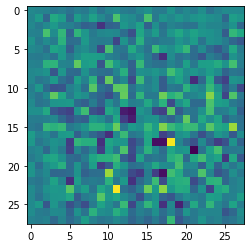

In [14]:
G_P = G(noise)
plt.imshow(G_P[0])

In [15]:
D_P = D(G_P)
print(D_P)

tf.Tensor(
[[ 1.9449199e-03]
 [-2.5351963e-04]
 [ 1.7015229e-03]
 [ 1.6823644e-03]
 [ 1.4855533e-03]
 [-1.2268557e-03]
 [ 2.0113513e-03]
 [ 3.9433143e-03]
 [ 1.1006135e-03]
 [ 2.7078814e-03]
 [ 2.0457171e-03]
 [ 5.7490577e-04]
 [ 1.3791965e-03]
 [-2.9685907e-08]
 [ 1.3930066e-03]
 [ 2.9984783e-04]], shape=(16, 1), dtype=float32)


In [16]:
#define loss function
def get_loss_fn():
    criterion = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    
    def d_loss_fn(real_logits,fake_logits):
        real_loss = criterion(tf.ones_like(real_logits),real_logits)
        fake_loss = criterion(tf.zeros_like(fake_logits),fake_logits)
        return real_loss+fake_loss
    
    def g_loss_fn(fake_logits):
        return criterion(tf.ones_like(fake_logits),fake_logits)
    
    return d_loss_fn,g_loss_fn

In [17]:
#data load & preprocessing
(train_x,_),(_,_) = tf.keras.datasets.fashion_mnist.load_data()
train_x = train_x[...,tf.newaxis].astype("float32")
train_x = (train_x - 127.5) / 127.5
train_ds = (
    tf.data.Dataset.from_tensor_slices(train_x)
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE,drop_remainder=True)
    .repeat()
)

train_ds_1 = (
    tf.data.Dataset.from_tensor_slices(train_x)
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE,drop_remainder=True)
)

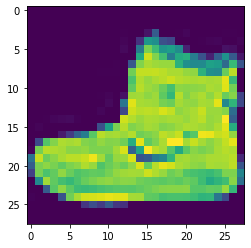

In [18]:
plt.imshow(train_x[0])

In [19]:
#ptimizer
g_optim = tf.keras.optimizers.Adam(G_LR,beta_1=0.5,beta_2=0.999)
d_optim = tf.keras.optimizers.Adam(D_LR,beta_1=0.5,beta_2=0.999 )

In [20]:
#get loss function
d_loss_fn,g_loss_fn = get_loss_fn()

In [21]:
@tf.function
def train_step(real_images):
    z = get_random_z(BATCH_SIZE,Z_DIM)
    with tf.GradientTape() as d_tape,tf.GradientTape() as g_tape:
        fake_images = G(z,training=True)
        
        fake_logits = D(fake_images,training=True)
        real_logits = D(real_images,training=True)
        
        d_loss = d_loss_fn(real_logits,fake_logits)
        g_loss = g_loss_fn(fake_logits)
        
        d_gradients = d_tape.gradient(d_loss,D.trainable_variables)
        g_gradients = g_tape.gradient(g_loss,G.trainable_variables)
        
        d_optim.apply_gradients(zip(d_gradients,D.trainable_variables))
        g_optim.apply_gradients(zip(g_gradients,G.trainable_variables))
        
    return g_loss,d_loss

In [22]:
@tf.function
def train_step_1(real_images):
    z = get_random_z(BATCH_SIZE,Z_DIM)
    with tf.GradientTape() as d_tape,tf.GradientTape() as g_tape:
        fake_images = G(z,training=True)
        
        fake_logits = D(fake_images,training=True)
        real_logits = D(real_images,training=True)
        
        d_loss = d_loss_fn(real_logits,fake_logits)
        g_loss = g_loss_fn(fake_logits)
        
        d_gradients = d_tape.gradient(d_loss,D.trainable_variables)
        g_gradients = g_tape.gradient(g_loss,G.trainable_variables)
        
        d_optim.apply_gradients(zip(d_gradients,D.trainable_variables))
        g_optim.apply_gradients(zip(g_gradients,G.trainable_variables))

In [23]:
#training loop
def train(ds,log_freq=20):
    ds = iter(ds)
    for step in range(ITERATION):
        images = next(ds)
        g_loss,d_loss = train_step(images)
        
        g_loss_metrics(g_loss)
        d_loss_metrics(d_loss)
        total_loss_metrics(g_loss + d_loss)
        
        if step % log_freq == 0:
            template = '[{}/{}] D_loss={:.5f} G_loss={:.5f} Total_loss={:.5f}'
            print(template.format(step,ITERATION,d_loss_metrics.result(),
                                 g_loss_metrics.result(),
                                 total_loss_metrics.result()))
            g_loss_metrics.reset_states()
            d_loss_metrics.reset_states()
            total_loss_metrics.reset_states()

In [24]:
#定义生成器可视化函数
def generate_plot_image(generator_model,test_noise):
    pre_images = generator_model(test_noise,training=False)
    #因为定义了seed为16张图片
    fig = plt.figure(figsize=(4,4))
    for i in range(pre_images.shape[0]):
        plt.subplot(4,4,i+1)
        plt.imshow((pre_images[i,:,:,0]+1)/2,cmap='gray')
        plt.axis('off')
    plt.show()

In [28]:
def train_1(dataset,epochs):
    for epoch in range(epochs):
        for image_batch in dataset:
            train_step_1(image_batch)
        generate_plot_image(G,noise)

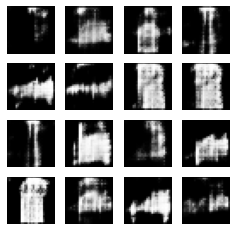

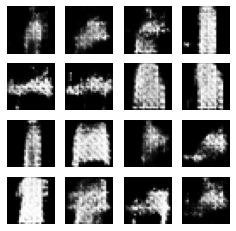

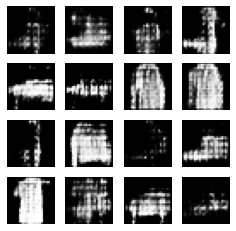

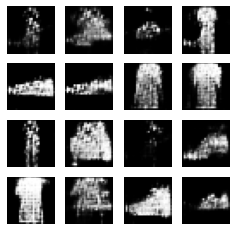

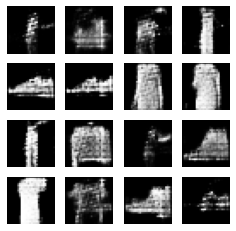

In [31]:
train_1(train_ds_1,5)